README -- Out of memory errors <br>
This code is tuned for a RTX3060 12GB, if you have less memory, you will likely get "out of memory" errors with this code, try to aggressively reduce batch size (you can increase epochs to compensate)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Attention Block - Scaled dot product attention

A very effective system that can find correlations between tokens is the attention block <br><br>

It takes in a series of tokens: input (sequence_length, embedding_size)<br>
we call this layer "attention head", you can have one head of self attention or many heads with different weights. <br> 
and computes the dot products with 3 sets of weights, called "keys", "queries" and "values" of size (emb_size, head_size) <br>
 
After this operation you have three tensors of size (sequence_length, head_size) <br>
you compute the similarity matrix (sequence_length, sequence_length) by multiplying keys with transposed queries. <br><br>

The next step is to tril (transform to lower triangular) and softmax the similarity matrix, and a scaling by sqrt(head_size) <br>
(This is why its called scaled dot product attention) <br>
Following is a dot product with the values. The output will be (sequence_length, head_size) <br>

This block has roughly a complexity of O(sequence_length^2) witch is sub optimal for long sequence lengths, so we use sligthly different attention blocks for that<br>

In [4]:
class Attention(nn.Module):  
    def __init__(self, emb_size, head_size):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=False):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        if mask: similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        
        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) # Residual connection not present in the original paper, but it helps with convergence
        x = self.fc2(x)
        return x


class Block(nn.Module): 
    def __init__(self, vocab_size, emb_size, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
        x = self.fcout(x)
    
        return x[:, -1]
    
device = torch.device("cuda:0")
model = Block(vocab_size=vocab_size, emb_size=10, head_size=32, hidden_size=32, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000  # doubled epochs 
batch_size = 2048  # halved batch size --> this reduces memory use
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

Millions of parameters: 0.01
Epoch ___0 - Loss: 4.425


KeyboardInterrupt: 

This performance is slightly worse than 20 layers MLP, but we are using just a single block (attention + 2 hidden layer MLP)

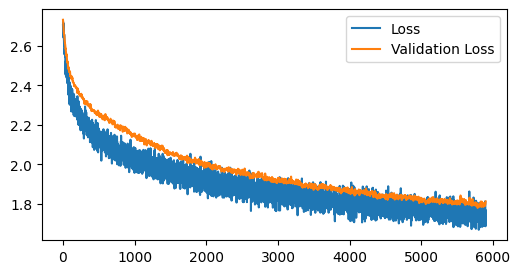

In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(lossi[100:], label='Loss')
plt.plot(vlossi[100:], label='Validation Loss')
plt.legend()

In [ ]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


           
KING RICHARD II:
Nay, re noble's am wo sovergot,
Which afful homely indeed,
What's lareful be gust march,
Call dowbry more of my tevert God bits.

Appedibless of you, sheld but is now;
That what whever, For us make will mady!
'Ty leave more bluctio,
That fortute fortuck our fathen:
Wherefold fai, she burrio des.


# Transformers 

Transformers consist of attention blocks in sequence, with residual connections 

In [5]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = self.prenorm1(x)
        x = x + self.att(x) 
        x = self.prenorm2(x)
        x = x + self.fc(x)
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x[:, -1]
    

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))

        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(loss.item())

# 1.6

Millions of parameters: 0.28
Epoch ___0 - Loss: 4.219


KeyboardInterrupt: 

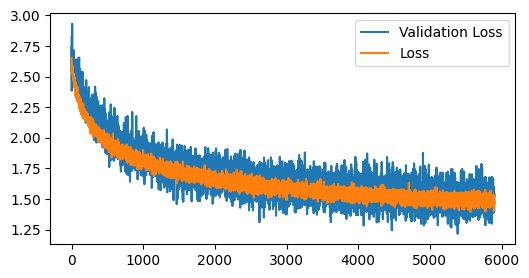

In [ ]:
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

# Results
As you can see we can get really good loss with the transformer, this architecture scales well up to GPT3.5 level performance with enough high quality data

In [ ]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  0.5
[16640, 5120, 256, 256, 32768, 128, 32768, 128, 32768, 128, 32768, 256, 256, 256, 32768, 128, 16384, 128, 16384, 128, 32768, 256, 256, 256, 32768, 128, 32768, 128, 32768, 128, 32768, 256, 256, 256, 32768, 128, 16384, 128, 16384, 128, 32768, 256, 16640, 65]


In [ ]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


           
KING RICHARD III:
Faith the has he wand.

First Senator:
Siry on The jesty ord, would Something:
So the worshiplo were his blood,
As and by defit a pardon,
Leadly the killy tursed: my sity
man must angrech and child
se loke thee with been
Comforticus!

PRINCE
TLERDIO:
Nor you are your person.

KING RICHARD III:
I